23:10:45 - cmdstanpy - INFO - Chain [1] start processing
23:10:45 - cmdstanpy - INFO - Chain [1] done processing



📊 Prophet Forecast Performance on Test Set:
MSE: 8516.37
RMSE: 92.28
MAE: 68.63
MAPE: 20.09%
R²: -0.2772
RRMSE: 0.3055
NRMSE: 0.2208


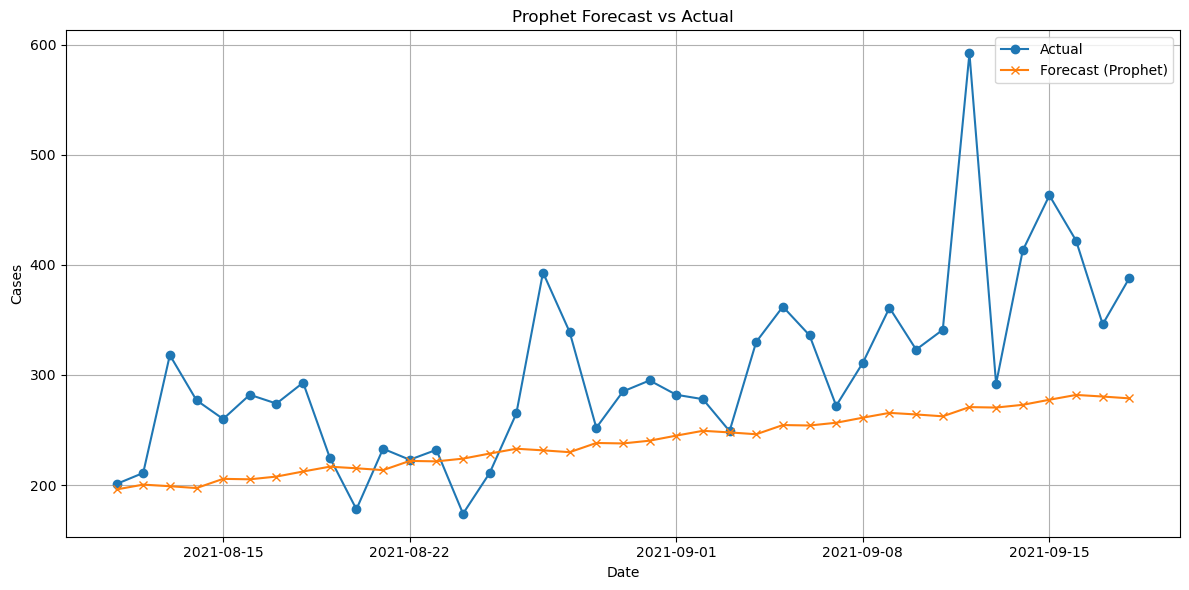

In [1]:
# === Import Libraries ===
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

# === Load Data ===
df = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")  # update your path if needed

# Rename columns for Prophet
df = df.rename(columns={'Date': 'ds', 'New deaths COVID-19 Cases': 'y'})

# Convert 'ds' to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Keep only necessary columns
df = df[['ds', 'y']].dropna()


# === Split Data into Train/Test ===
train_end = '2021-08-10'
test_start = '2021-08-11'
test_end = '2021-09-18'

train = df[df['ds'] <= train_end]
test = df[(df['ds'] >= test_start) & (df['ds'] <= test_end)]

# === Fit Prophet Model ===
model = Prophet()
model.fit(train)

# === Make Future DataFrame ===
future = model.make_future_dataframe(periods=len(test), freq='D')

# === Forecast ===
forecast = model.predict(future)

# === Extract Forecasted Values ===
forecast_test = forecast[['ds', 'yhat']].set_index('ds').loc[test_start:test_end]
actual_test = test.set_index('ds')

# === Evaluation Metrics ===
y_true = actual_test['y']
y_pred = forecast_test['yhat']

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2 = r2_score(y_true, y_pred)
rrmse = rmse / np.mean(y_true)
nrmse = rmse / (max(y_true) - min(y_true))

print(f"\n📊 Prophet Forecast Performance on Test Set:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")

# === Plot Forecast vs Actual ===
plt.figure(figsize=(12, 6))
plt.plot(y_true.index, y_true, label='Actual', marker='o')
plt.plot(y_pred.index, y_pred, label='Forecast (Prophet)', marker='x')
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
# === Actual vs Forecasted Values (12–18 Sept 2021) ===
comparison = pd.DataFrame({
    'Date': actual_test.loc['2021-09-12':'2021-09-18'].index,
    'Actual': actual_test.loc['2021-09-12':'2021-09-18']['y'].values,
    'Forecast': forecast_test.loc['2021-09-12':'2021-09-18']['yhat'].values
})

print("\n📌 Actual vs Forecasted (12–18 Sept 2021):")
print(comparison)



📌 Actual vs Forecasted (12–18 Sept 2021):
        Date  Actual    Forecast
0 2021-09-12     592  270.791712
1 2021-09-13     292  270.380702
2 2021-09-14     413  272.867041
3 2021-09-15     463  277.470777
4 2021-09-16     422  281.846457
5 2021-09-17     346  280.398259
6 2021-09-18     388  278.723571



📊 XGBoost Forecast Evaluation on Test Set:
MSE: 25107.97
RMSE: 158.45
MAE: 132.96
MAPE: 39.87%
R²: -2.7656
RRMSE: 0.5245
NRMSE: 0.3791


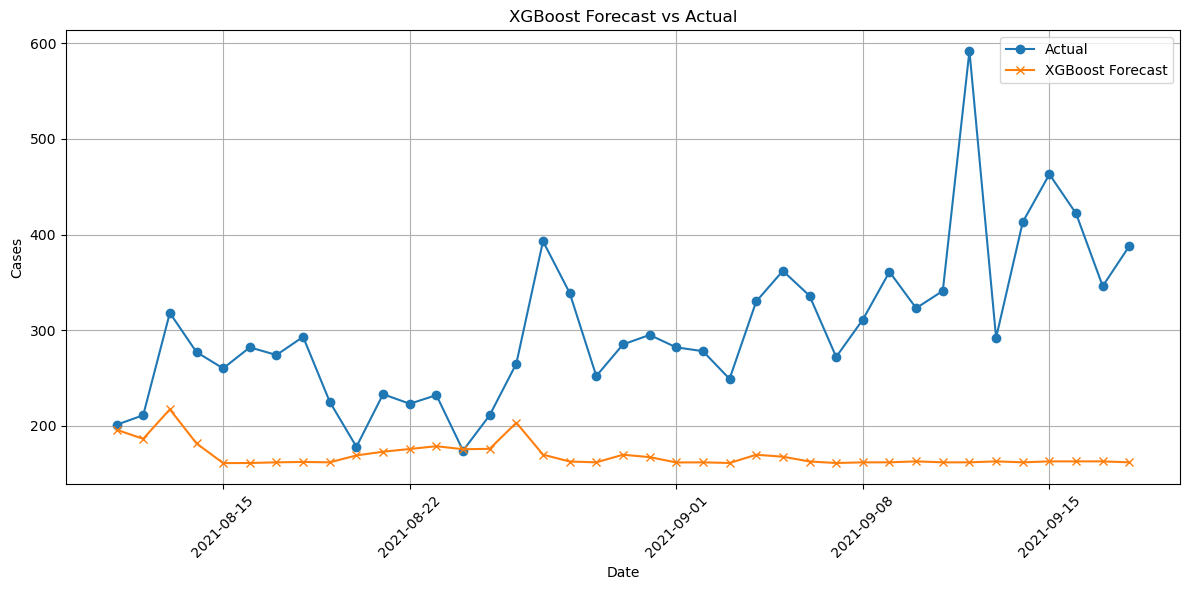


📌 XGBoost Forecast (12/09/2021 - 18/09/2021):
         Date  Actual    Forecast       Error     %Error
32 2021-09-12     592  161.736206  430.263794  72.679695
33 2021-09-13     292  162.728790  129.271210  44.270962
34 2021-09-14     413  161.736206  251.263794  60.838691
35 2021-09-15     463  162.728790  300.271210  64.853393
36 2021-09-16     422  162.728790  259.271210  61.438675
37 2021-09-17     346  162.728790  183.271210  52.968558
38 2021-09-18     388  161.736206  226.263794  58.315411


In [3]:
# === Import Libraries ===
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Load your data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")  # Update file path
data = data.rename(columns={'New deaths COVID-19 Cases': 'y'})  # Rename target column
data['Date'] = pd.to_datetime(data['Date'])  # Ensure Date is datetime
data = data.sort_values('Date').reset_index(drop=True)

# === Create lag features ===
def create_lag_features(df, lag_days):
    for lag in lag_days:
        df[f'lag_{lag}'] = df['y'].shift(lag)
    return df

lag_days = [1, 2, 3, 7, 14]
data = create_lag_features(data, lag_days)
data = data.dropna()

# === Train-test split ===
train_end = '2021-08-10'
test_start = '2021-08-11'
test_end = '2021-09-18'

train = data[(data['Date'] <= train_end)]
test = data[(data['Date'] >= test_start) & (data['Date'] <= test_end)]

feature_cols = [f'lag_{lag}' for lag in lag_days]
X_train = train[feature_cols]
y_train = train['y']
X_test = test[feature_cols]
y_test = test['y']

# === Fit XGBoost Model ===
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

# === Make predictions ===
y_pred = xgb.predict(X_test)

# === Evaluation metrics ===
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)
rrmse = rmse / y_test.mean()
nrmse = rmse / (y_test.max() - y_test.min())

print("\n📊 XGBoost Forecast Evaluation on Test Set:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")

# === Plot actual vs predicted ===
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test.values, label='Actual', marker='o')
plt.plot(test['Date'], y_pred, label='XGBoost Forecast', marker='x')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('XGBoost Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Extract Actual vs Forecast for 12/09/2021 to 18/09/2021 ===
comparison_xgb = pd.DataFrame({
    'Date': test['Date'].values,
    'Actual': y_test.values,
    'Forecast': y_pred
})

comparison_xgb = comparison_xgb[(comparison_xgb['Date'] >= '2021-09-12') &
                                (comparison_xgb['Date'] <= '2021-09-18')]

# Add error metrics for each day
comparison_xgb['Error'] = comparison_xgb['Actual'] - comparison_xgb['Forecast']
comparison_xgb['%Error'] = (comparison_xgb['Error'] / comparison_xgb['Actual']) * 100

print("\n📌 XGBoost Forecast (12/09/2021 - 18/09/2021):")
print(comparison_xgb)




📊 SVR Forecast Evaluation on Test Set:
MSE: 67276.45
RMSE: 259.38
MAE: 245.84
MAPE: 80.03%
R²: -9.0898
RRMSE: 0.8586
NRMSE: 0.6205

📅 Actual vs Forecast (12–18 Sept 2021):
          Date  Actual  Forecast
244 2021-09-12     592        55
245 2021-09-13     292        55
246 2021-09-14     413        55
247 2021-09-15     463        55
248 2021-09-16     422        55
249 2021-09-17     346        55
250 2021-09-18     388        55


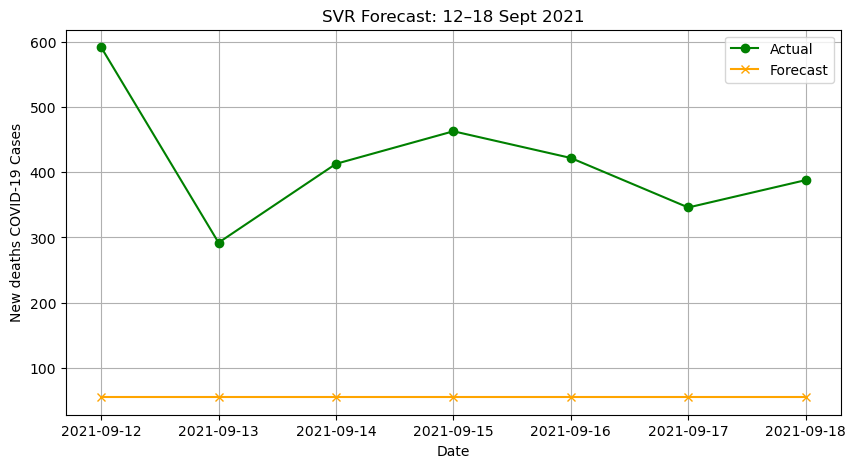

In [4]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Step 1: Load and preprocess data ===

data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")  # Update file path
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Filter dataset between Jan 4, 2021, and Sep 18, 2021
data_filtered = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# Keep target series for comparison
target_series = data_filtered[['Date', 'New deaths COVID-19 Cases']].copy()

# === Step 2: Create lag features ===
for lag in range(1, 8):
    data_filtered[f"lag_{lag}"] = data_filtered["New deaths COVID-19 Cases"].shift(lag)

data_filtered = data_filtered.dropna().reset_index(drop=True)

# === Step 3: Split into train/val/test ===
train_set = data_filtered[(data_filtered['Date'] >= '2021-01-04') & (data_filtered['Date'] <= '2021-07-02')]
val_set   = data_filtered[(data_filtered['Date'] >= '2021-07-03') & (data_filtered['Date'] <= '2021-08-10')]
test_set  = data_filtered[(data_filtered['Date'] >= '2021-08-11') & (data_filtered['Date'] <= '2021-09-18')]

# Features and target
X_train, y_train = train_set.drop(columns=['Date','New deaths COVID-19 Cases']).values, train_set['New deaths COVID-19 Cases'].values
X_val,   y_val   = val_set.drop(columns=['Date','New deaths COVID-19 Cases']).values,   val_set['New deaths COVID-19 Cases'].values
X_test,  y_test  = test_set.drop(columns=['Date','New deaths COVID-19 Cases']).values,  test_set['New deaths COVID-19 Cases'].values

# Scale features only
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# === Step 4: Train SVR ===
model = SVR(kernel="rbf", C=100, gamma=0.01, epsilon=50)
model.fit(X_train, y_train)

# === Step 5: Predictions ===
val_pred  = model.predict(X_val)
test_pred = model.predict(X_test)

# === Step 6: Evaluate overall test ===
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_pred)
mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
r2 = r2_score(y_test, test_pred)
rrmse = rmse / y_test.mean()
nrmse = rmse / (y_test.max() - y_test.min())

print("\n📊 SVR Forecast Evaluation on Test Set:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")

# === Step 7: Focus only on 12/09/21 - 18/09/21 ===
mask = (test_set['Date'] >= '2021-09-12') & (test_set['Date'] <= '2021-09-18')
subset_dates = test_set.loc[mask, 'Date']
subset_actual = y_test[mask]
subset_pred   = test_pred[mask]

# Table of actual vs predicted
forecast_table = pd.DataFrame({
    "Date": subset_dates,
    "Actual": subset_actual,
    "Forecast": subset_pred.round(0).astype(int)
})
print("\n📅 Actual vs Forecast (12–18 Sept 2021):")
print(forecast_table)

# === Step 8: Plot ===
plt.figure(figsize=(10,5))
plt.plot(subset_dates, subset_actual, marker="o", label="Actual", color="green")
plt.plot(subset_dates, subset_pred, marker="x", label="Forecast", color="orange")
plt.legend()
plt.title("SVR Forecast: 12–18 Sept 2021")
plt.xlabel("Date")
plt.ylabel("New deaths COVID-19 Cases")
plt.grid(True)
plt.show()


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0026 - val_loss: 0.0227
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.3219e-04 - val_loss: 0.0097
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.1700e-04 - val_loss: 0.0049
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.5344e-04 - val_loss: 0.0046
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.2014e-04 - val_loss: 0.0046
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.1008e-04 - val_loss: 0.0051
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.5468e-04 - val_loss: 0.0051
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.0001e-04 - val_loss: 0.0048
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.0612e-04 - val_loss: 0.0048
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.0582e-04 - val_loss: 0.0049
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.5562e-04 - val_loss: 0.0051
Epoch 12/50
11/11 ━━━━━

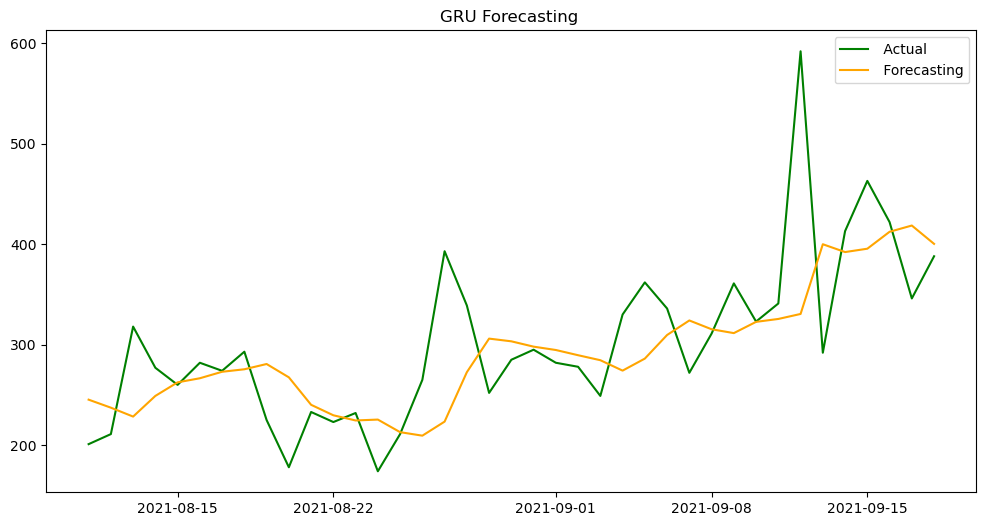

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# === Step 1: Load and preprocess data ===
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Filter dataset between Jan 4, 2021, and Sep 18, 2021
data_filtered = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# Keep only target series
cases = data_filtered[['Date', 'New deaths COVID-19 Cases']].copy()

# Normalize target
scaler = MinMaxScaler()
cases['scaled_cases'] = scaler.fit_transform(cases[['New deaths COVID-19 Cases']])

# === Step 2: Create supervised sequences ===
def create_sequences(series, window_size=7):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 7  # past 7 days to predict next day
X, y = create_sequences(cases['scaled_cases'].values, window_size)

# Align with dates
dates = cases['Date'][window_size:].reset_index(drop=True)

# === Step 3: Train/val/test split ===
train_mask = (dates >= '2021-01-04') & (dates <= '2021-07-02')
val_mask   = (dates >= '2021-07-03') & (dates <= '2021-08-10')
test_mask  = (dates >= '2021-08-11') & (dates <= '2021-09-18')

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

# Reshape for GRU [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val   = X_val.reshape((X_val.shape[0],   X_val.shape[1],   1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1],  1))

# === Step 4: Build GRU model ===
model = Sequential()
model.add(GRU(64, activation='tanh', return_sequences=False, input_shape=(window_size,1)))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predict next day cases
model.compile(optimizer='adam', loss='mse')

# === Step 5: Train model ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)

# === Step 6: Predictions ===
y_test_pred = model.predict(X_test)

# Inverse scale back to actual cases
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

# === Step 6: Evaluate overall test ===
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_pred)
mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
r2 = r2_score(y_test, test_pred)
rrmse = rmse / y_test.mean()
nrmse = rmse / (y_test.max() - y_test.min())

print("\n📊 SVR Forecast Evaluation on Test Set:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")

# === Step 8: Extract only 12–18 Sept 2021 forecast ===
mask_12_18 = (dates[test_mask] >= '2021-09-12') & (dates[test_mask] <= '2021-09-18')
forecast_df = pd.DataFrame({
    "Date": dates[test_mask][mask_12_18].values,
    "Actual": y_test_actual[mask_12_18].flatten(),
    "Predicted": y_test_pred[mask_12_18].flatten()
})

print("\n📌 GRU Forecast (12–18 Sept 2021):")
print(forecast_df)

# === Step 9: Plot ===
plt.figure(figsize=(12,6))
plt.plot(dates[test_mask], y_test_actual, label=" Actual", color="green")
plt.plot(dates[test_mask], y_test_pred, label=" Forecasting", color="orange")
plt.legend()
plt.title("GRU Forecasting ")
plt.show()



📌 GARCH Forecast (12/09/2021 - 18/09/2021):
            Actual    Forecast
2021-09-12     592  374.783749
2021-09-13     292  411.874870
2021-09-14     413  452.636486
2021-09-15     463  497.485560
2021-09-16     422  546.902628
2021-09-17     346  601.494059
2021-09-18     388  662.024459

📊 Evaluation Metrics:
MSE: 31468.64
RMSE: 177.39
MAE: 152.23
MAPE: 38.41%
R²: -3.0576
RRMSE: 0.4258
NRMSE: 0.5913


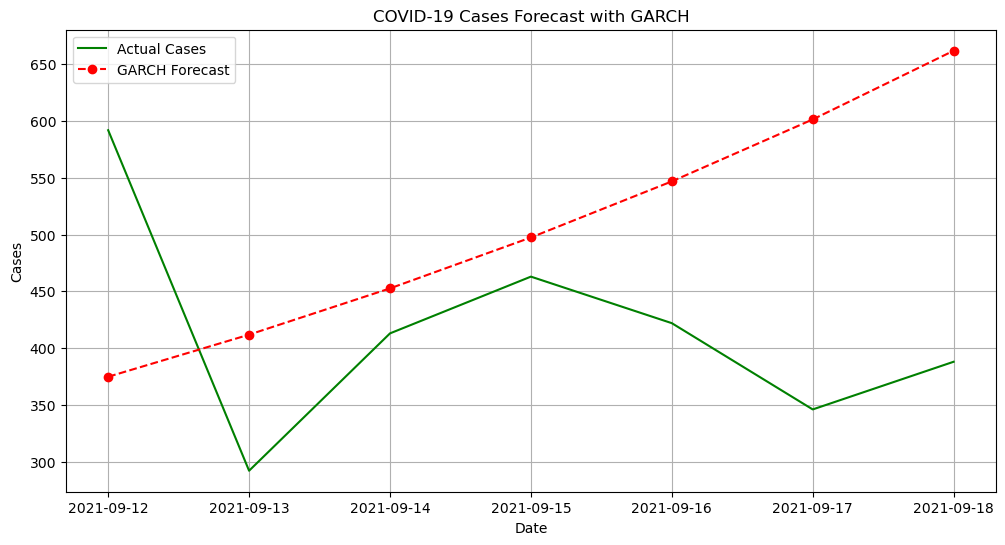

In [6]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Step 1: Load Data ===
df = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Target series
series = df.set_index("Date")['New deaths COVID-19 Cases']

# === Step 2: Returns for GARCH ===
returns = 100 * series.pct_change().dropna()

# === Step 3: Define forecast period (12–18 Sept 2021) ===
start_date = '2021-09-12'
end_date   = '2021-09-18'
forecast_dates = pd.date_range(start=start_date, end=end_date)

# Training data: all before forecast start
train_returns = returns.loc[:'2021-09-11']
history = list(train_returns.values)

rolling_forecast_garch = []

# === Step 4: Rolling 1-step-ahead forecasts ===
for date in forecast_dates:
    model = arch_model(history, vol="GARCH", p=1, q=1, dist="normal")
    model_fit = model.fit(disp="off")

    forecast = model_fit.forecast(horizon=1)
    next_return = forecast.mean.iloc[-1, 0]  # forecasted return (%)
    rolling_forecast_garch.append(next_return)

    # Update history with predicted return
    history.append(next_return)

# === Step 5: Convert returns → cases ===
last_actual = series.loc['2021-09-11']  # last observed before forecast
predicted_cases = [last_actual * (1 + rolling_forecast_garch[0]/100)]
for r in rolling_forecast_garch[1:]:
    predicted_cases.append(predicted_cases[-1] * (1 + r/100))

forecast_cases_garch = pd.Series(predicted_cases, index=forecast_dates)

# === Step 6: Actual vs Forecast ===
actual_cases = series.loc[start_date:end_date]
comparison = pd.DataFrame({
    "Actual": actual_cases,
    "Forecast": forecast_cases_garch
})

# === Step 7: Evaluation Metrics ===
mse = mean_squared_error(comparison["Actual"], comparison["Forecast"])
mae = mean_absolute_error(comparison["Actual"], comparison["Forecast"])
mape = np.mean(np.abs((comparison["Actual"] - comparison["Forecast"]) / comparison["Actual"])) * 100
rmse = np.sqrt(mse)
rrmse = rmse / np.mean(comparison["Actual"])
nrmse = rmse / (comparison["Actual"].max() - comparison["Actual"].min())
r2 = r2_score(comparison["Actual"], comparison["Forecast"])

print("\n📌 GARCH Forecast (12/09/2021 - 18/09/2021):")
print(comparison)
print("\n📊 Evaluation Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")

# === Step 8: Plot ===
plt.figure(figsize=(12,6))
plt.plot(series.loc['2021-09-12':'2021-09-18'], label="Actual Cases", color="green")
plt.plot(forecast_cases_garch, label="GARCH Forecast", color="red", linestyle="--", marker="o")
plt.title("COVID-19 Cases Forecast with GARCH")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.show()


E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                   SARIMAX Results                                   
Dep. Variable:     New deaths COVID-19 Cases   No. Observations:                  219
Model:                        ARIMA(0, 3, 2)   Log Likelihood               -1014.622
Date:                       Mon, 22 Sep 2025   AIC                           2035.245
Time:                               23:18:52   BIC                           2045.370
Sample:                           01-04-2021   HQIC                          2039.336
                                - 08-10-2021                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9974      0.573     -3.486      0.000      -3.121      -0.874
ma.L2          0.9996      0.574      1.743      0.081      -0.125       2.

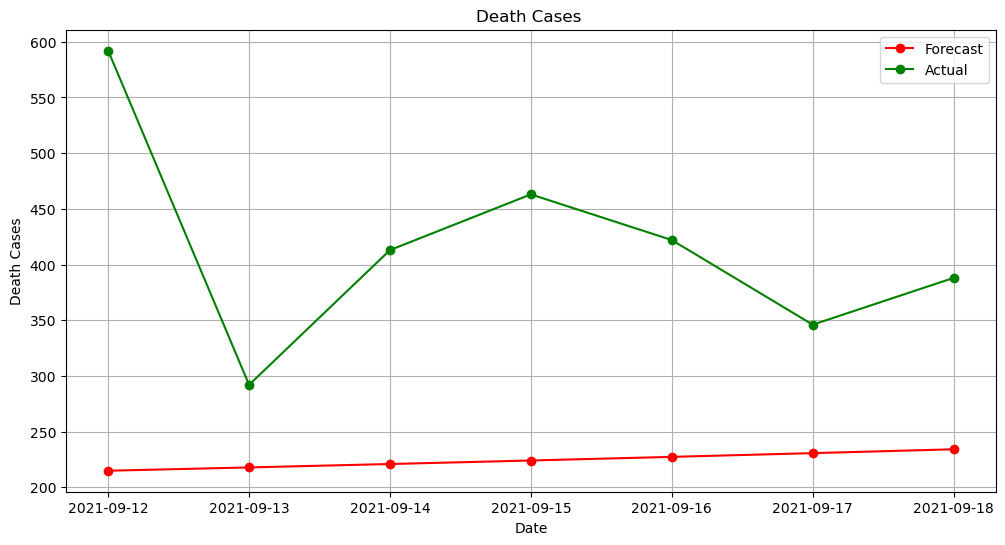

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# === Step 1: Load and preprocess data ===
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Filter dataset between Jan 4, 2021, and Sep 18, 2021
data_filtered = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# Keep original Date column separately
dates = data_filtered['Date']

# Normalize all columns except Date
scaler = MinMaxScaler()
features = data_filtered.drop(columns=['Date'])
normalized_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
normalized_features['Date'] = dates

# === Step 2: Split into train/val/test ===
train_set = normalized_features[(normalized_features['Date'] >= '2021-01-04') & (normalized_features['Date'] <= '2021-07-02')]
val_set = normalized_features[(normalized_features['Date'] >= '2021-07-03') & (normalized_features['Date'] <= '2021-08-10')]
test_set = normalized_features[(normalized_features['Date'] >= '2021-08-11') & (normalized_features['Date'] <= '2021-09-18')]

# Reset index for each
train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

# === Step 3: Time series model on actual cases ===
# We'll use unnormalized actual cases for ARIMA forecasting
covid_cases_ts = data_filtered.set_index('Date')['New deaths COVID-19 Cases']  # Replace 'Cases' with your actual column name

# Train ARIMA model on training + validation set
arima_train_series = covid_cases_ts['2021-01-04':'2021-08-10']
arima_model = ARIMA(arima_train_series, order=(0,3,2))  # You can optimize (p,d,q) or use auto_arima
arima_model = arima_model.fit()

# Print the model summary
print(arima_model.summary())

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Step 4: Forecast and evaluate
test_data = covid_cases_ts['2021-08-11':'2021-09-18']
forecast = arima_model.forecast(steps=len(test_data))
forecast = pd.Series(forecast, index=test_data.index)

# Metrics
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(test_data) - np.min(test_data))
nrmse = rmse / np.mean(test_data)  # Normalized RMSE by mean
r2 = r2_score(test_data, forecast)

# Print results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
# Assuming your model is called `arima_model`
forecast = arima_model.forecast(steps=7)  # 7 days forecast
forecast.index = pd.date_range(start='2021-09-12', periods=7, freq='D')
print(forecast)
# === Step 5: Forecast for 12/09/2021 - 18/09/2021 ===
forecast_range = arima_model.forecast(steps=7)
forecast_range.index = pd.date_range(start='2021-09-12', periods=7, freq='D')

# Actual values for the same period
actual_range = covid_cases_ts['2021-09-12':'2021-09-18']

# === Step 6: Plot ===
plt.figure(figsize=(12,6))

plt.plot(forecast_range.index, forecast_range, label="Forecast", color="red", marker="o")
plt.plot(actual_range.index, actual_range, label="Actual", color="green", marker="o")

plt.title("Death Cases ")
plt.xlabel("Date")
plt.ylabel("Death Cases")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/200


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0340
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0100
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023  
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022  
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031
Epoch 13/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040
Epoch 14/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031
Epoch 15/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.00

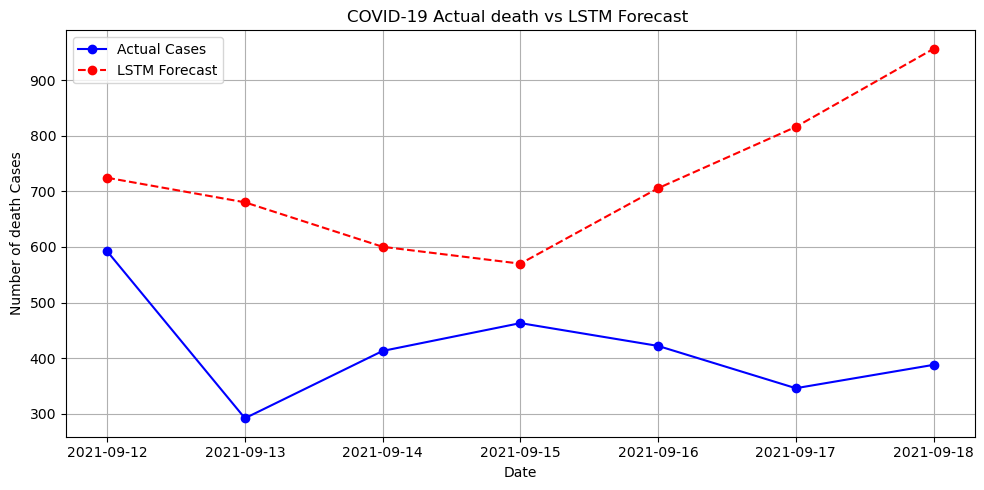

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# === Step 1: Load and preprocess data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

target_col = 'New deaths COVID-19 Cases'
target_series = data[[target_col, 'Date']].copy()

# === Step 2: Train-test split (same as ARIMA example) ===
train_data = target_series[(target_series['Date'] <= '2021-08-10')]
test_data = target_series[(target_series['Date'] >= '2021-08-11') & (target_series['Date'] <= '2021-09-18')]

# === Step 3: Normalize data (only on train) ===
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[[target_col]])
test_scaled = scaler.transform(test_data[[target_col]])

# === Step 4: Create sequences for LSTM ===
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 10
x_train, y_train = create_sequences(train_scaled, seq_length)
x_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape to (samples, seq_length, features)
x_train = x_train.reshape((x_train.shape[0], seq_length, 1))
x_test = x_test.reshape((x_test.shape[0], seq_length, 1))

# === Step 5: Build and train LSTM model ===
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=200, batch_size=16, verbose=1)

# === Step 6: Predict on test set ===
y_pred = model.predict(x_test)

# Inverse scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# === Step 7: Evaluate LSTM model ===
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(y_test_rescaled) - np.min(y_test_rescaled))
nrmse = rmse / np.mean(y_test_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print("\n📊 Final LSTM Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# === Step 8: Rolling Forecast for 12–18 Sep 2021 ===
forecast_horizon = pd.date_range(start='2021-09-12', end='2021-09-18')

last_sequence = test_scaled[-seq_length:]  # last window from test
forecast_scaled = []

for _ in range(len(forecast_horizon)):
    input_seq = last_sequence.reshape((1, seq_length, 1))
    next_scaled = model.predict(input_seq, verbose=0)[0][0]
    forecast_scaled.append([next_scaled])
    last_sequence = np.vstack((last_sequence[1:], [[next_scaled]]))

forecast_scaled = np.array(forecast_scaled)
forecast_rescaled = scaler.inverse_transform(forecast_scaled)

lstm_forecast_series = pd.Series(forecast_rescaled.flatten(), index=forecast_horizon)

print("\n📈 LSTM Rolling Forecast (12–18 Sep 2021):")
print(lstm_forecast_series)

# === Step 9: Plot Actual vs Forecast (12–18 Sep 2021 only) ===
plt.figure(figsize=(10,5))

# Actual observed cases in forecast horizon
actual_forecast_period = target_series.set_index("Date").loc["2021-09-12":"2021-09-18", target_col]

# Plot actual
plt.plot(actual_forecast_period.index, actual_forecast_period.values,
         label="Actual Cases", color="blue", marker="o")

# Plot forecast
plt.plot(lstm_forecast_series.index, lstm_forecast_series.values,
         label="LSTM Forecast", color="red", linestyle="--", marker="o")

plt.title("COVID-19 Actual death vs LSTM Forecast ")
plt.xlabel("Date")
plt.ylabel("Number of death Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


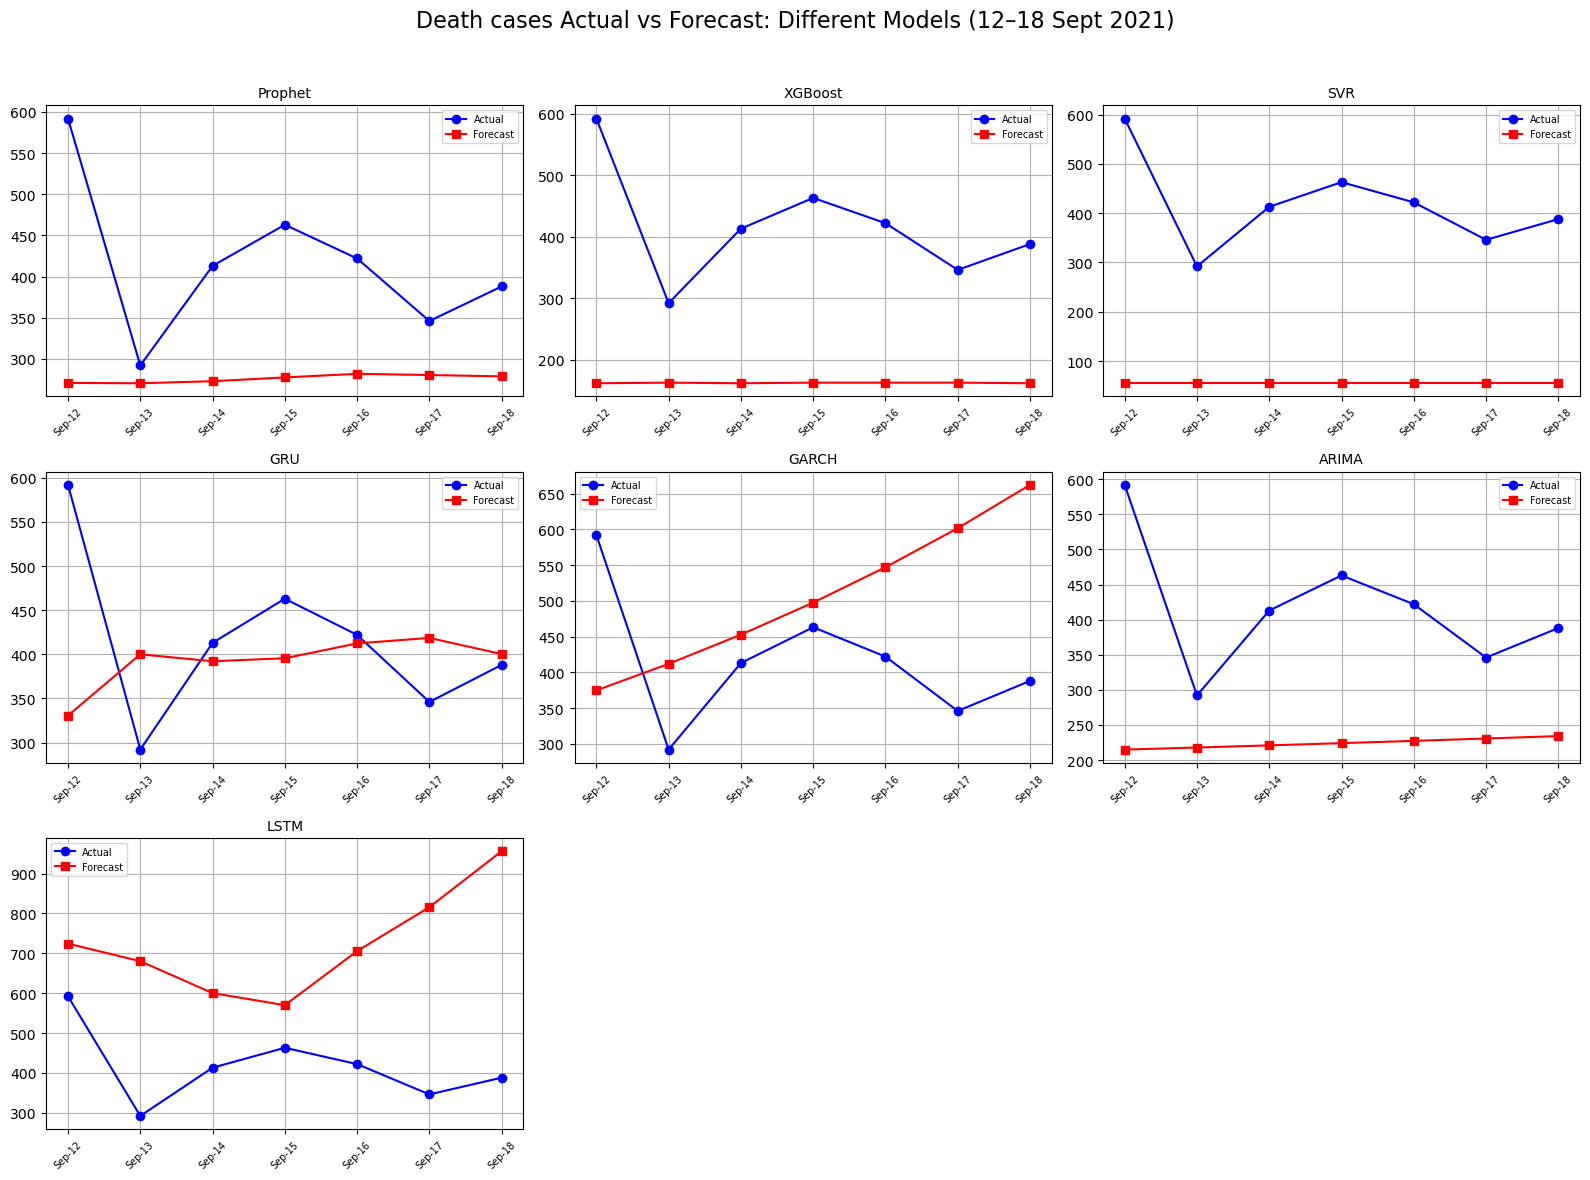

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -----------------------------
# Step 1. Build DataFrames
# -----------------------------

# Prophet
prophet = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [270.79, 270.38, 272.87, 277.47, 281.85, 280.40, 278.72]
})

# XGBoost
xgb = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [161.73, 162.72, 161.73, 162.72, 162.72, 162.72, 161.73]
})

# SVR
svr = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [55, 55, 55, 55, 55, 55, 55]
})

# GRU
gru = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [330.57, 399.95, 392.17, 395.50, 412.36, 418.57, 400.32]
})

# GARCH
garch = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [374.78, 411.87, 452.63, 497.48, 546.90, 601.49, 662.02]
})

# ARIMA
arima = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [214.86, 217.82, 220.88, 224.03, 227.29, 230.65, 234.10]
})

# LSTM
lstm = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [724.28, 680.14, 600.17, 569.87, 705.49, 815.74, 956.07]
})

# -----------------------------
# Step 2. Put into dictionary
# -----------------------------
models = {
    "Prophet": prophet,
    "XGBoost": xgb,
    "SVR": svr,
    "GRU": gru,
    "GARCH": garch,
    "ARIMA": arima,
    "LSTM": lstm
}

# -----------------------------
# Step 3. Individual subplots
# -----------------------------
rows, cols = 3, 3  # enough for 7 models
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()

for i, (name, df) in enumerate(models.items()):
    ax = axes[i]
    ax.plot(df["Date"], df["Actual"], marker="o", label="Actual", color="blue")
    ax.plot(df["Date"], df["Forecast"], marker="s", label="Forecast", color="red")
    ax.set_title(name, fontsize=10)
    ax.legend(fontsize=7)
    ax.grid(True)

    # fix date labels
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
    ax.tick_params(axis="x", rotation=45, labelsize=7)

# remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Death cases Actual vs Forecast: Different Models (12–18 Sept 2021)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# -----------------------------



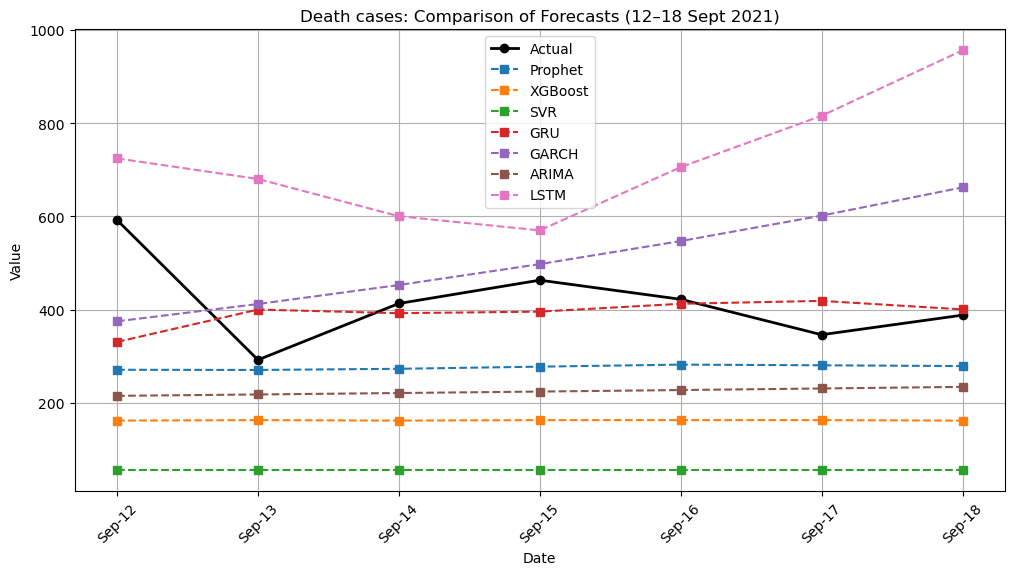

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -----------------------------
# Step 1. Build DataFrames
# -----------------------------

# Prophet
prophet = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [270.79, 270.38, 272.87, 277.47, 281.85, 280.40, 278.72]
})

# XGBoost
xgb = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [161.73, 162.72, 161.73, 162.72, 162.72, 162.72, 161.73]
})

# SVR
svr = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [55, 55, 55, 55, 55, 55, 55]
})

# GRU
gru = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [330.57, 399.95, 392.17, 395.50, 412.36, 418.57, 400.32]
})

# GARCH
garch = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [374.78, 411.87, 452.63, 497.48, 546.90, 601.49, 662.02]
})

# ARIMA
arima = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [214.86, 217.82, 220.88, 224.03, 227.29, 230.65, 234.10]
})

# LSTM
lstm = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [592, 292, 413, 463, 422, 346, 388],
    "Forecast": [724.28, 680.14, 600.17, 569.87, 705.49, 815.74, 956.07]
})

# -----------------------------
# Step 2. Put into dictionary
# -----------------------------
models = {
    "Prophet": prophet,
    "XGBoost": xgb,
    "SVR": svr,
    "GRU": gru,
    "GARCH": garch,
    "ARIMA": arima,
    "LSTM": lstm
}


# -----------------------------

plt.figure(figsize=(12, 6))
plt.plot(prophet["Date"], prophet["Actual"], marker="o", label="Actual", color="black", linewidth=2)

for name, df in models.items():
    plt.plot(df["Date"], df["Forecast"], marker="s", linestyle="--", label=name)

plt.title("Death cases: Comparison of Forecasts (12–18 Sept 2021)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# fix date labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
plt.xticks(rotation=45)

plt.show()